# Making use of Playoff Game Logs <img src="playoffs.jpeg" style="height:100px" align = 'right' />

We're looking at historical NBA playoff series data, on a period by period level. I will go through how I pull the data using python's [nba_api](https://github.com/swar/nba_api) package. We will look at data from seasons `1996-97` through `2024-25`.

In [1]:
import nba_api.stats.endpoints as nba
import pandas as pd
import time
from nba_api.stats.static import teams

Using `TeamGameLogs`, we can pull historical game logs from previous seasons.

In [2]:
def get_game_log(season,measure_type="Base",stype = "Playoffs",location = None):
	df = nba.TeamGameLogs(season_nullable=season,location_nullable = location,measure_type_player_game_logs_nullable=measure_type,season_type_nullable = stype).get_data_frames()[0]
	df = df.rename(columns = {"SEASON_YEAR":"season","TEAM_ABBREVIATION":"team","GAME_DATE":"date"})
	return df

In [3]:
seasons = [str(i)+'-'+str(i+1)[2:] for i in range(1996,2025)]
season = seasons[0]
df = get_game_log(season)
for season in seasons[1:]:
	P = get_game_log(season)
	df = pd.concat([df,P])
	time.sleep(0.5)

Now that we've pulled from the api, we can have a cursory look at what the data looks like. Let's look at the important columns.

In [4]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df.loc[:,['date','team','MATCHUP','WL','PTS','PLUS_MINUS']].set_index('date').tail()

,team,MATCHUP,WL,PTS,PLUS_MINUS
date,,,,,
2025-05-04,IND,IND @ CLE,W,121,9.0
2025-05-05,BOS,BOS vs. NYK,L,105,-3.0
2025-05-05,OKC,OKC vs. DEN,L,119,-2.0
2025-05-05,DEN,DEN @ OKC,W,121,2.0
2025-05-05,NYK,NYK @ BOS,W,108,3.0


We see that the last five rows in the dataset show that the Knicks lost by three, Wolves won by 7, Rockets won by 15, Lakers lost by 7, and Warriors lost by 15. Notice that there are **two rows per game**, one for the home team and one for the away team.

## Wrangling until we have the right setup
Now, if we want want to look at different playoffs scenarios, we need to do some wrangling. I will create the following columns:
- `opp` = Opponent Team abbreviation
- `is_home` = **True** if game is at home, **False** if away
- `game_no` = **1** for first game of the series, **2** for the second, etc..
- `round_no` = **1** (first round), **2** (conference semfinals), **3** (conference finals), and **4** (finals)
- `series` - current series standing (e.g. **3-1** if the team is up **3-1** going into the game)
- `total_games` - total number of games the series went to.
- `has_home_court` - **True** if a team has home court in the series, **False** otherwise.

*Note*: The wrangling below only works if your original DataFrame is correctly sorted by date.

In [5]:
# create 'is_home' and 'opp' columns
df['is_home'] = df['MATCHUP'].str.contains("vs.")
df['opp'] = df['MATCHUP'].apply(lambda x: x.split(' ')[-1])


In [6]:
MIN = df[df['team'] == 'MIN']
MIN.loc[:,['date','team','opp','MATCHUP','WL']].set_index('date').tail(5)

,team,opp,MATCHUP,WL
date,,,,
2025-04-19,MIN,LAL,MIN @ LAL,W
2025-04-22,MIN,LAL,MIN @ LAL,L
2025-04-25,MIN,LAL,MIN vs. LAL,W
2025-04-27,MIN,LAL,MIN vs. LAL,W
2025-04-30,MIN,LAL,MIN @ LAL,W


To create the `game_no` column, I will use pandas's [df.groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) meathod on `season`,`team` and `opp`, along with a temporary `counter` combined with [pd.cumsum()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.cumsum.html). This is a very common/standard workflow in data cleaning.


In [7]:
# Create the 'game_no' column
df['counter'] = 1
df['game_no'] = df.groupby(['season','team','opp'])['counter'].cumsum()
df = df.drop(columns = ['counter'])

In [8]:
MIN = df[df['team'] == 'MIN']
MIN.loc[:,['date','team','opp','game_no','WL']].set_index('date').tail(5)

,team,opp,game_no,WL
date,,,,
2025-04-19,MIN,LAL,1,W
2025-04-22,MIN,LAL,2,L
2025-04-25,MIN,LAL,3,W
2025-04-27,MIN,LAL,4,W
2025-04-30,MIN,LAL,5,W


Now to create the `series` column, I first create `series_wins` and `series_losses` columns. Then I will concatenate the two joined by a *-* in between.

In [9]:
# get the current number of series wins
df['win'] = 0
df.loc[df['WL']=='W','win'] = 1
df['series_wins'] = df.groupby(['season','team','opp'])['win'].transform(lambda x: x.cumsum().shift().fillna(0))
df['series_wins'] = df['series_wins'].astype(int)

#get the current number of series losses
df['loss'] = 0
df.loc[df['WL']=='L','loss'] = 1
df['series_losses'] = df.groupby(['season','team','opp'])['loss'].transform(lambda x: x.cumsum().shift().fillna(0))
df['series_losses'] = df['series_losses'].astype(int)



# create a 'series' column (represents what the series is at going into the game)
def do_series(s):
    w,l = s['series_wins'],s['series_losses']
    return str(w)+'-'+str(l)
df['series'] = df.apply(do_series,axis = 1)

In [12]:
df[df['is_home']].loc[:,['date','team','opp','series_wins','series_losses','series','PTS','PLUS_MINUS','win']].set_index('date').tail(10)

,team,opp,series_wins,series_losses,series,PTS,PLUS_MINUS,win
date,,,,,,,,
2025-04-30,LAL,MIN,1,3,1-3,96,-7.0,0
2025-04-30,HOU,GSW,1,3,1-3,131,15.0,1
2025-05-01,LAC,DEN,2,3,2-3,111,6.0,1
2025-05-01,DET,NYK,2,3,2-3,113,-3.0,0
2025-05-02,GSW,HOU,3,2,3-2,107,-8.0,0
2025-05-03,DEN,LAC,3,3,3-3,120,19.0,1
2025-05-04,HOU,GSW,3,3,3-3,89,-14.0,0
2025-05-04,CLE,IND,0,0,0-0,112,-9.0,0
2025-05-05,BOS,NYK,0,0,0-0,105,-3.0,0


In [13]:
MIN = df[df['team'] == 'MIN']
MIN.loc[:,['date','team','opp','game_no','series','WL']].set_index('date').tail(5)

,team,opp,game_no,series,WL
date,,,,,
2025-04-19,MIN,LAL,1,0-0,W
2025-04-22,MIN,LAL,2,1-0,L
2025-04-25,MIN,LAL,3,1-1,W
2025-04-27,MIN,LAL,4,2-1,W
2025-04-30,MIN,LAL,5,3-1,W


Neat! 😇. Just what I wanted to do: we see that the wolves won in 5. Coming into the game, they were up **3-1**, and this is reflected in the `series` column.

To create the `round_no` column, I first create a dataframe that contains all the opponents a team faced that year. Then I return the index for that team.

In [14]:
# Create a 'round_no' column (1 = first round, 2 = second round, 3 = third round, 4 = fourth round)
opponents_faced = df.groupby(['season','team'])['opp'].unique()
def get_round_number(s):
    season,team,opp = s['season'],s['team'],s['opp']
    k = (season,team)
    l = opponents_faced.loc[k].tolist()
    return l.index(opp)+1
df['round_no'] = df.apply(get_round_number,axis = 1)

Now to create the `total_games` column, I group by matchup and use the pandas' `.size()` method. This allows me to return the size of each group.

In [15]:
# get the total number of games
totals = df.groupby(['season','team','opp']).size()
def get_num_games(s):
    season,team,matchup = s['season'],s['team'],s['opp']
    k = (season,team,matchup)
    return totals.loc[k]
df['total_games'] = df.apply(get_num_games,axis = 1)	


To create the `has_home_court` column, I look at the first game of each series to determine who has home court advantage. Then, I use pandas [pd.merge](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) to add this column to our DataFrame.

In [16]:
# Create the 'has_home_court' in series column
X = df.groupby(['season','team','opp']).first()['is_home']
X = X.reset_index()
X = X.rename(columns = {'is_home':'has_home_court'})
df = pd.merge(df,X, on = ['season','team','opp'], how = 'left')

In [17]:
MIN = df[df['team'] == 'MIN']
MIN.loc[:,['date','team','opp','game_no','round_no','has_home_court','series','WL']].set_index('date').tail(5)

,team,opp,game_no,round_no,has_home_court,series,WL
date,,,,,,,
2025-04-19,MIN,LAL,1,1,False,0-0,W
2025-04-22,MIN,LAL,2,1,False,1-0,L
2025-04-25,MIN,LAL,3,1,False,1-1,W
2025-04-27,MIN,LAL,4,1,False,2-1,W
2025-04-30,MIN,LAL,5,1,False,3-1,W


The TWolves were the 6 seed, the Lakers the 3 seed. So this is why the `has_home_court` is **False** for this series.

In [20]:
df[df['is_home']].loc[:,['date','team','opp','round_no','game_no','series','PTS','PLUS_MINUS','win']].set_index('date').tail(5)

,team,opp,round_no,game_no,series,PTS,PLUS_MINUS,win
date,,,,,,,,
2025-05-03,DEN,LAC,1,7,3-3,120,19.0,1
2025-05-04,HOU,GSW,1,7,3-3,89,-14.0,0
2025-05-04,CLE,IND,2,1,0-0,112,-9.0,0
2025-05-05,BOS,NYK,2,1,0-0,105,-3.0,0
2025-05-05,OKC,DEN,2,1,0-0,119,-2.0,0


# What can we do with our data?

Let's see what our added columns look like:

In [21]:
df.loc[:,['date','team','opp','is_home','has_home_court','game_no','round_no','series','WL']].set_index('date').tail()

,team,opp,is_home,has_home_court,game_no,round_no,series,WL
date,,,,,,,,
2025-05-04,IND,CLE,False,False,1,2,0-0,W
2025-05-05,BOS,NYK,True,True,1,2,0-0,L
2025-05-05,OKC,DEN,True,True,1,2,0-0,L
2025-05-05,DEN,OKC,False,False,1,2,0-0,W
2025-05-05,NYK,BOS,False,False,1,2,0-0,W


As you can see above, the last rows in our data are up-to-date: the **Celtics** were home last night against the **Magic** (Apr 29, 2025), they have home court in the series, and the series was at **3-1** going into the game. Meanwhile, the **Clippers** went into **Denver** tied **2-2**, they don't have home court in the series, and they lost last night.

## How do higher seeded teams perform by game number?

Let's look at how the team with home court advantage fares depending on the game number.

In [22]:
FILTER = df['has_home_court']
WINNING_PCTS = df.loc[FILTER].groupby(['game_no'])['win'].mean()
WINNING_PCTS = WINNING_PCTS.apply(lambda x: round(x,3))
WINNING_PCTS

game_no
1    0.715
2    0.743
3    0.470
4    0.506
5    0.742
6    0.532
7    0.662
Name: win, dtype: float64

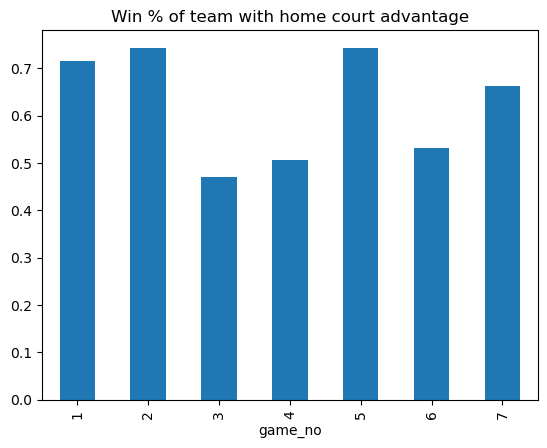

In [23]:
PLOT = WINNING_PCTS.plot.bar(title = 'Win % of team with home court advantage')

There is a noticeable drop in game 7 win percentage. I would allocate this to the fact that if an opponent takes a team to a seventh game, they are probably a good team, so they win more often!

Let's cut the data in half (pre-2011 and 2011+) to see if these trends continue. 

In [24]:
df['post-10'] = df['season'].isin(seasons[15:])

In [25]:
FILTER = df['has_home_court']
WINNING_PCTS = df.loc[FILTER].groupby(['post-10','game_no'])['win'].mean()
WINNING_PCTS = WINNING_PCTS.apply(lambda x: round(x,3))
WINNING_PCTS = WINNING_PCTS.reset_index()
WINNING_PCTS

,post-10,game_no,win
0,False,1,0.747
1,False,2,0.764
2,False,3,0.440
3,False,4,0.495
4,False,5,0.776
5,False,6,0.490
6,False,7,0.765
7,True,1,0.680
8,True,2,0.719
9,True,3,0.502


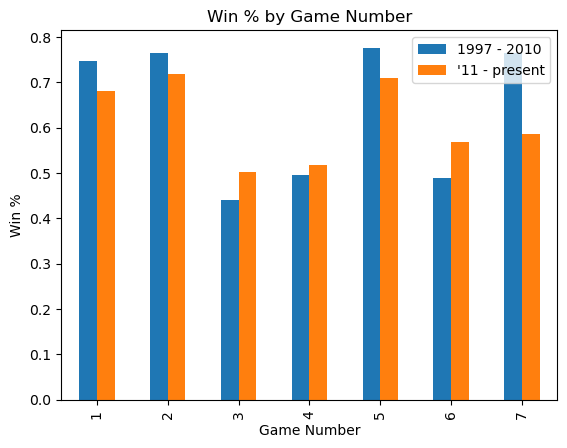

In [26]:
# Pivot for side-by-side bar plot
pivot_df = WINNING_PCTS.pivot(index='game_no', columns='post-10', values='win')

# Rename columns for clarity
pivot_df.columns = ["1997 - 2010", "'11 - present"]  # False comes first, True second

# Plot
PLOT = pivot_df.plot(kind='bar', ylabel='Win %', xlabel='Game Number', title='Win % by Game Number')

What I notice most is the drop in Game 7 win percentages for the home team. In *recent history* (2011 and later), game sevens have been won by the road team more frequently. However, game sevens are somewhat rare, so we are dealing with a small sample size in both cases. What is interesting, however, is that home teams seem to perform slightly less well in *recent history*.

### Why didn't I just use an LLM?

I don't know about you, but when I use an LLM to write my code, I get paranoid. Plus, I started working with data *before* LLMs. I simply feel more comfortable cleaning the data manually myself than having a back and forth an AI until the software understands what I am trying to do.

Now that we just witnessed three straight road victories in game 1, let's see how common this has been.

In [29]:
A = ~df['has_home_court'].astype(bool)
B = df['game_no'] == 1
FILTER = A&B
dftemp = df.loc[FILTER].groupby('round_no')[['win','PLUS_MINUS']].agg(['count','mean'])
dftemp.apply(lambda x: round(x,2))

win       PLUS_MINUS      
         count  mean      count  mean
round_no                             
1          232  0.27        232 -7.57
2          115  0.31        115 -6.33
3           56  0.36         56 -5.25
4           28  0.14         28 -9.18

<Axes: title={'center': "Home Team's Playoff win pct by year"}, xlabel='season'>

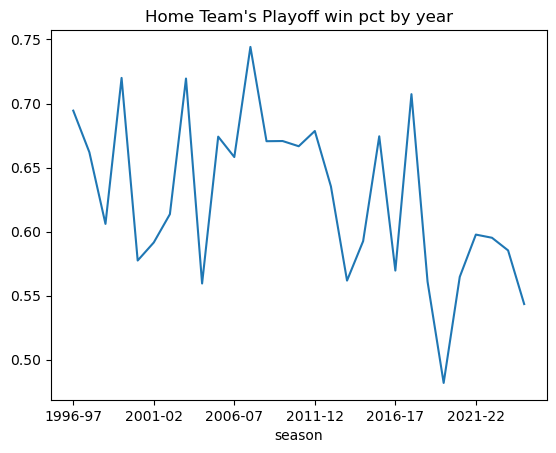

In [36]:
DATA = df[df['is_home']].groupby('season')['win'].mean()
DATA.plot(title = "Home Team's Playoff win pct by year")

<Axes: title={'center': "Higher-seeded Team's Home Win Percentage"}, xlabel='season'>

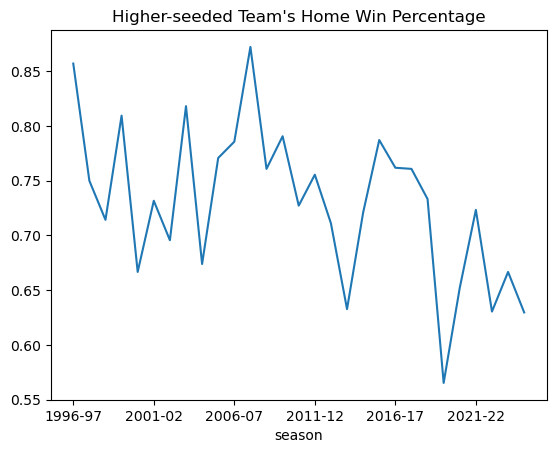

In [45]:
FILTER = (df['is_home']) & (df['has_home_court'])
DATA = df.loc[FILTER].groupby('season')['win'].mean()
DATA.plot(title = "Higher-seeded Team's Home Win Percentage")